In [2]:
import pandas as pd
import numpy as np
import yaml
import matplotlib.pyplot as plt
import seaborn as sns
import prince
import optuna
import tensorflow as tf
import catboost
import sklearn

from sklearn.base import BaseEstimator,TransformerMixin, ClassifierMixin
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, GridSearchCV, RandomizedSearchCV, validation_curve
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, RobustScaler, OneHotEncoder, PolynomialFeatures, StandardScaler, SplineTransformer, KBinsDiscretizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, f1_score, roc_curve, auc, recall_score, precision_recall_curve, make_scorer, confusion_matrix, ConfusionMatrixDisplay
from sklearn.kernel_approximation import Nystroem
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, VotingClassifier
from sklearn.utils.class_weight import compute_class_weight

from prince import FAMD

from scipy.stats import chi2_contingency

from catboost import CatBoostClassifier,Pool, cv
from catboost.utils import eval_metric

from optuna.samplers import TPESampler

import shap

c:\Users\dcons\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
file = open('../../../conf/global_conf.yml', 'r') 
conf = yaml.safe_load(file)
df = pd.read_csv(conf['local_data_path'] + "data_cleaned_final_sans_dummies.csv",index_col=0,low_memory=False)

In [13]:
print('The catboost version is {}.'.format(catboost.__version__))
print('The shap version is {}.'.format(shap.__version__))
print('The scikit-learn version is {}.'.format(sklearn.__version__))
print('The optuna version is {}.'.format(optuna.__version__))
print('The prince version is {}.'.format(prince.__version__))
print('The yaml version is {}.'.format(yaml.__version__))


The catboost version is 1.2.5.
The shap version is 0.45.1.
The scikit-learn version is 1.4.1.post1.
The optuna version is 3.6.1.
The prince version is 0.13.0.
The yaml version is 6.0.1.


In [4]:
# Recodage variable cible grav par ordre croissant : 0 : indemne, 1 : blessé léger, 2 : blessé grave, 3 : décès
with pd.option_context("future.no_silent_downcasting", True):
    df['grav'] = df['grav'].replace(1,'I')
    df['grav'] = df['grav'].replace(2,'T')
    df['grav'] = df['grav'].replace(3,'BG')
    df['grav'] = df['grav'].replace(4,'BL')
    df['grav'] = df['grav'].replace('I',0)
    df['grav'] = df['grav'].replace('T',3)
    df['grav'] = df['grav'].replace('BG',2)
    df['grav'] = df['grav'].replace('BL',1)

In [5]:
print(df.shape)

(447136, 41)


In [6]:
data = df.drop(['grav_rec', 'an', 'jour', 'date', 'grav', 'dep'], axis=1)

y = df.grav
numerical_features = ['age_usager', 'mois', 'heure', 'lat', 'long']
categorical_features = [col for col in data.columns if col not in numerical_features]
for col in categorical_features:
    data[col] = data[col].astype('int')
data[categorical_features] = data[categorical_features].astype('object')

#data.info()

In [7]:
data.head()

,mois,lum,agg,int,atm,col,lat,long,catr,circ,...,eq_ceinture,eq_casque,eq_siege,eq_gilet,eq_airbag,eq_gants,eq_indetermine,eq_autre,jour_chome,prox_pt_choc
0,11,2,0,0,0,2,48.896210,2.470120,1,0,...,1,0,0,0,0,0,0,0,1,0
1,11,2,0,0,0,2,48.896210,2.470120,1,0,...,1,0,0,0,0,0,0,0,1,0
2,11,2,0,0,0,2,48.896210,2.470120,1,0,...,1,0,0,0,0,0,0,0,1,1
3,11,2,0,0,0,6,48.930700,2.368800,1,0,...,1,0,0,0,0,0,0,0,1,1
4,11,0,0,0,0,4,48.935872,2.319174,1,0,...,1,0,0,0,0,0,0,0,1,1


In [8]:
data_train, data_test, y_train, y_test = train_test_split(data, y, test_size=0.25, random_state=42, stratify=y)

**Catboost**

In [9]:
categorical_numbers = [data.columns.values.tolist().index(i) for i in data.select_dtypes(include=['object']).columns]
print(categorical_numbers)

[1, 2, 3, 4, 5, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]


In [10]:
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))
class_weights

{0: 0.6057177536467477,
 1: 0.6196864536443666,
 2: 1.5969447037086422,
 3: 9.161621680690635}

In [11]:
cv_dataset = Pool(data = data_train,
                  label = y_train,
                  cat_features = categorical_numbers,
                  weight = y_train.map(class_weights))

In [11]:
params = {"iterations": 500,
          "depth": 2,
          "loss_function": "MultiClassOneVsAll",
          "verbose": False}

In [12]:
scores = cv(cv_dataset, params, fold_count=2, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/2]

bestTest = 0.4407618228
bestIteration = 499

Training on fold [1/2]

bestTest = 0.4392486288
bestIteration = 499



**Optimisation de certains hyperparamètres avec la librairie Optuna**

In [12]:
data__train, data__val, y__train, y__val = train_test_split(data_train, y_train, test_size=0.25, random_state=42, stratify=y_train)

In [13]:
train_dataset = Pool(data = data__train,
                     label = y__train,
                     cat_features = categorical_numbers,
                     weight = y__train.map(class_weights))


eval_dataset = Pool(data = data__val,
                   label = y__val,
                   cat_features = categorical_numbers,
                   weight = y__val.map(class_weights))

In [16]:
def objective(trial):
    params = {
        'iterations' : trial.suggest_int('iterations', 250, 400),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 5, 10),
        'grow_policy' : trial.suggest_categorical('grow_policy', ["SymmetricTree", "Lossguide"]),
        'loss_function' :  trial.suggest_categorical('loss_function', ["MultiClass", "MultiClassOneVsAll"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0)
    }

    model = CatBoostClassifier(**params,  random_seed=42)
    model.fit(train_dataset, eval_set=eval_dataset)
    preds = model.predict(eval_dataset)
    y_pred = [int(val[0]) for val in preds]
    cat_f1 = f1_score(eval_dataset.get_label(), y_pred, average = 'micro')
    return cat_f1

sampler = TPESampler(seed=123, multivariate=True, group=True)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=20, n_jobs=-1)

c:\Users\dcons\anaconda3\Lib\site-packages\optuna\samplers\_tpe\sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(
c:\Users\dcons\anaconda3\Lib\site-packages\optuna\samplers\_tpe\sampler.py:330: ExperimentalWarning: ``group`` option is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2024-05-24 18:03:33,246] A new study created in memory with name: no-name-27fe15f2-f868-492d-aadf-f3fc9327bf11


0:	learn: 0.6403402	test: 0.6403402	best: 0.6403402 (0)	total: 390ms	remaining: 2m 18s
0:	learn: 0.6018431	test: 0.6018431	best: 0.6018431 (0)	total: 591ms	remaining: 3m 48s
0:	learn: 0.6832184	test: 0.6832184	best: 0.6832184 (0)	total: 550ms	remaining: 3m 24s
1:	learn: 0.6092733	test: 0.6092733	best: 0.6092733 (1)	total: 1.02s	remaining: 3m 1s
1:	learn: 0.5745575	test: 0.5745575	best: 0.5745575 (1)	total: 1.37s	remaining: 4m 24s
1:	learn: 0.6740743	test: 0.6740743	best: 0.6740743 (1)	total: 1.33s	remaining: 4m 6s
2:	learn: 0.5859846	test: 0.5859601	best: 0.5859601 (2)	total: 1.73s	remaining: 3m 24s
2:	learn: 0.6656463	test: 0.6656463	best: 0.6656463 (2)	total: 1.84s	remaining: 3m 47s
2:	learn: 0.5659962	test: 0.5659962	best: 0.5659962 (2)	total: 2.05s	remaining: 4m 22s
3:	learn: 0.6578729	test: 0.6578729	best: 0.6578729 (3)	total: 2.28s	remaining: 3m 30s
3:	learn: 0.5633940	test: 0.5633940	best: 0.5633940 (3)	total: 2.54s	remaining: 4m 3s
0:	learn: 0.6301229	test: 0.6301256	best: 0.63

[I 2024-05-24 18:11:57,389] Trial 2 finished with value: 0.5982967150933944 and parameters: {'iterations': 357, 'learning_rate': 0.23997787389749112, 'depth': 6, 'l2_leaf_reg': 8.233401633604304, 'grow_policy': 'SymmetricTree', 'loss_function': 'MultiClassOneVsAll', 'colsample_bylevel': 0.050101029924937764}. Best is trial 2 with value: 0.5982967150933944.


53:	learn: 0.4023648	test: 0.4135919	best: 0.4135919 (53)	total: 8m 22s	remaining: 47m 34s
253:	learn: 0.3918050	test: 0.4173212	best: 0.4173212 (253)	total: 8m 22s	remaining: 4m 22s
106:	learn: 0.9587408	test: 0.9684069	best: 0.9684069 (106)	total: 8m 21s	remaining: 11m 43s
138:	learn: 0.4102388	test: 0.4159892	best: 0.4159892 (138)	total: 8m 21s	remaining: 6m 44s
147:	learn: 0.9558529	test: 0.9678487	best: 0.9678487 (147)	total: 8m 21s	remaining: 8m 54s
212:	learn: 0.4269487	test: 0.4290131	best: 0.4290131 (212)	total: 8m 20s	remaining: 6m 16s
112:	learn: 0.3727865	test: 0.4101152	best: 0.4101152 (112)	total: 8m 23s	remaining: 19m 50s
254:	learn: 0.3916499	test: 0.4173301	best: 0.4173212 (253)	total: 8m 24s	remaining: 4m 21s
148:	learn: 0.9556928	test: 0.9677513	best: 0.9677513 (148)	total: 8m 24s	remaining: 8m 51s
213:	learn: 0.4268828	test: 0.4289416	best: 0.4289416 (213)	total: 8m 24s	remaining: 6m 14s
139:	learn: 0.4102061	test: 0.4159672	best: 0.4159672 (139)	total: 8m 25s	remai

[I 2024-05-24 18:17:26,430] Trial 6 finished with value: 0.6020658889763592 and parameters: {'iterations': 387, 'learning_rate': 0.47879596493916604, 'depth': 8, 'l2_leaf_reg': 8.741800444963339, 'grow_policy': 'Lossguide', 'loss_function': 'MultiClassOneVsAll', 'colsample_bylevel': 0.10616975110868701}. Best is trial 6 with value: 0.6020658889763592.


309:	learn: 0.4194890	test: 0.4226251	best: 0.4226251 (309)	total: 13m 49s	remaining: 2m 48s
92:	learn: 0.3924030	test: 0.4117453	best: 0.4117453 (92)	total: 13m 51s	remaining: 39m 56s
184:	learn: 0.3503751	test: 0.4104155	best: 0.4100884 (119)	total: 13m 52s	remaining: 14m 37s
39:	learn: 0.4270100	test: 0.4288113	best: 0.4288113 (39)	total: 5m 28s	remaining: 34m 55s
233:	learn: 0.9410536	test: 0.9591399	best: 0.9591399 (233)	total: 13m 52s	remaining: 4m 16s
175:	learn: 0.9403356	test: 0.9582570	best: 0.9582570 (175)	total: 13m 52s	remaining: 6m 23s
233:	learn: 0.4040509	test: 0.4129306	best: 0.4129306 (233)	total: 13m 53s	remaining: 1m
0:	learn: 0.5997989	test: 0.5997989	best: 0.5997989 (0)	total: 1.38s	remaining: 6m 23s
310:	learn: 0.4194250	test: 0.4225836	best: 0.4225836 (310)	total: 13m 52s	remaining: 2m 46s
1:	learn: 0.5733275	test: 0.5733275	best: 0.5733275 (1)	total: 2.63s	remaining: 6m 3s
2:	learn: 0.5654431	test: 0.5654431	best: 0.5654431 (2)	total: 3.92s	remaining: 5m 59s
17

[I 2024-05-24 18:18:32,418] Trial 1 finished with value: 0.5958395954101958 and parameters: {'iterations': 251, 'learning_rate': 0.17761708562954356, 'depth': 5, 'l2_leaf_reg': 7.232863733215192, 'grow_policy': 'SymmetricTree', 'loss_function': 'MultiClassOneVsAll', 'colsample_bylevel': 0.3304442336062382}. Best is trial 6 with value: 0.6020658889763592.


45:	learn: 0.4240040	test: 0.4262457	best: 0.4262457 (45)	total: 6m 32s	remaining: 35m 25s
100:	learn: 0.3905065	test: 0.4115420	best: 0.4115420 (100)	total: 14m 57s	remaining: 38m 29s
248:	learn: 0.9386338	test: 0.9578359	best: 0.9578359 (248)	total: 14m 55s	remaining: 3m 25s
196:	learn: 0.3462566	test: 0.4106323	best: 0.4100884 (119)	total: 14m 57s	remaining: 13m 54s
187:	learn: 0.9375611	test: 0.9569468	best: 0.9569468 (187)	total: 14m 57s	remaining: 5m 29s
327:	learn: 0.4186108	test: 0.4220041	best: 0.4220041 (327)	total: 14m 56s	remaining: 2m 3s
9:	learn: 0.4439658	test: 0.4456183	best: 0.4456183 (9)	total: 1m 6s	remaining: 29m 31s
0:	learn: 0.6014604	test: 0.6014604	best: 0.6014604 (0)	total: 745ms	remaining: 4m 52s
1:	learn: 0.5743225	test: 0.5743225	best: 0.5743225 (1)	total: 1.56s	remaining: 5m 4s
249:	learn: 0.9384549	test: 0.9577272	best: 0.9577272 (249)	total: 14m 59s	remaining: 3m 21s
2:	learn: 0.5658882	test: 0.5658882	best: 0.5658882 (2)	total: 2.63s	remaining: 5m 42s
32

[I 2024-05-24 18:21:00,721] Trial 5 finished with value: 0.5862258164555452 and parameters: {'iterations': 373, 'learning_rate': 0.040543009641539555, 'depth': 7, 'l2_leaf_reg': 9.599229789440919, 'grow_policy': 'Lossguide', 'loss_function': 'MultiClassOneVsAll', 'colsample_bylevel': 0.16522443171887435}. Best is trial 6 with value: 0.6020658889763592.


121:	learn: 0.3862901	test: 0.4112768	best: 0.4112228 (111)	total: 17m 25s	remaining: 34m 7s
32:	learn: 0.4186117	test: 0.4240137	best: 0.4240137 (32)	total: 3m 32s	remaining: 26m 21s
221:	learn: 0.9301894	test: 0.9540069	best: 0.9540069 (221)	total: 17m 25s	remaining: 2m 44s
290:	learn: 0.9339750	test: 0.9556007	best: 0.9556007 (290)	total: 17m 25s	remaining: 53.9s
39:	learn: 0.4155132	test: 0.4215631	best: 0.4215631 (39)	total: 2m 29s	remaining: 21m 55s
232:	learn: 0.3357126	test: 0.4116807	best: 0.4100884 (119)	total: 17m 28s	remaining: 11m 1s
65:	learn: 0.4185785	test: 0.4218266	best: 0.4218266 (65)	total: 9m 4s	remaining: 31m 30s
33:	learn: 0.4183186	test: 0.4239752	best: 0.4239752 (33)	total: 3m 38s	remaining: 26m 4s
222:	learn: 0.9300379	test: 0.9539241	best: 0.9539241 (222)	total: 17m 30s	remaining: 2m 40s
291:	learn: 0.9339657	test: 0.9555940	best: 0.9555940 (291)	total: 17m 30s	remaining: 50.3s
40:	learn: 0.4153224	test: 0.4214311	best: 0.4214311 (40)	total: 2m 32s	remaining:

[I 2024-05-24 18:22:08,440] Trial 4 finished with value: 0.595445979150266 and parameters: {'iterations': 306, 'learning_rate': 0.1356757865416458, 'depth': 4, 'l2_leaf_reg': 6.970429661120401, 'grow_policy': 'Lossguide', 'loss_function': 'MultiClass', 'colsample_bylevel': 0.7863066918927064}. Best is trial 6 with value: 0.6020658889763592.


54:	learn: 0.4117487	test: 0.4197914	best: 0.4197914 (54)	total: 3m 34s	remaining: 21m 58s
244:	learn: 0.3332904	test: 0.4121795	best: 0.4100884 (119)	total: 18m 35s	remaining: 10m 14s
234:	learn: 0.9279467	test: 0.9530702	best: 0.9530702 (234)	total: 18m 35s	remaining: 1m 44s
42:	learn: 0.4150919	test: 0.4222258	best: 0.4222258 (42)	total: 4m 43s	remaining: 25m 51s
130:	learn: 0.3845862	test: 0.4111585	best: 0.4111487 (129)	total: 18m 37s	remaining: 32m 41s
55:	learn: 0.4114731	test: 0.4197429	best: 0.4197429 (55)	total: 3m 38s	remaining: 21m 56s
245:	learn: 0.3330163	test: 0.4122237	best: 0.4100884 (119)	total: 18m 40s	remaining: 10m 10s
0:	learn: 1.2443079	test: 1.2449704	best: 1.2449704 (0)	total: 6s	remaining: 32m 41s
73:	learn: 0.4167464	test: 0.4204131	best: 0.4204131 (73)	total: 10m 16s	remaining: 30m 41s
56:	learn: 0.4111682	test: 0.4195952	best: 0.4195952 (56)	total: 3m 42s	remaining: 21m 53s
235:	learn: 0.9278142	test: 0.9530004	best: 0.9530004 (235)	total: 18m 41s	remaining

[I 2024-05-24 18:24:11,494] Trial 7 finished with value: 0.5975214103389871 and parameters: {'iterations': 257, 'learning_rate': 0.11281568321193981, 'depth': 6, 'l2_leaf_reg': 8.312122430931659, 'grow_policy': 'Lossguide', 'loss_function': 'MultiClass', 'colsample_bylevel': 0.4150670188848211}. Best is trial 6 with value: 0.6020658889763592.


268:	learn: 0.3273832	test: 0.4131692	best: 0.4100884 (119)	total: 20m 35s	remaining: 8m 29s
81:	learn: 0.4064909	test: 0.4180124	best: 0.4179564 (77)	total: 5m 37s	remaining: 21m 21s
58:	learn: 0.4100925	test: 0.4204141	best: 0.4204132 (55)	total: 6m 43s	remaining: 24m 59s
85:	learn: 0.4147379	test: 0.4193444	best: 0.4193444 (85)	total: 12m 12s	remaining: 29m 40s
146:	learn: 0.3815312	test: 0.4110148	best: 0.4110148 (146)	total: 20m 39s	remaining: 30m 3s
0:	learn: 0.6160054	test: 0.6160054	best: 0.6160054 (0)	total: 1.5s	remaining: 7m 42s
20:	learn: 0.9810814	test: 0.9913494	best: 0.9913494 (20)	total: 2m 5s	remaining: 30m 29s
1:	learn: 0.5847842	test: 0.5847842	best: 0.5847842 (1)	total: 2.61s	remaining: 6m 40s
2:	learn: 0.5716229	test: 0.5716229	best: 0.5716229 (2)	total: 3.85s	remaining: 6m 33s
82:	learn: 0.4063724	test: 0.4179486	best: 0.4179486 (82)	total: 5m 43s	remaining: 21m 22s
269:	learn: 0.3268877	test: 0.4133220	best: 0.4100884 (119)	total: 20m 42s	remaining: 8m 26s
8:	lea

[I 2024-05-24 18:33:41,929] Trial 0 finished with value: 0.606431451131945 and parameters: {'iterations': 380, 'learning_rate': 0.21842390574080756, 'depth': 10, 'l2_leaf_reg': 7.517648987603563, 'grow_policy': 'SymmetricTree', 'loss_function': 'MultiClassOneVsAll', 'colsample_bylevel': 0.09378570526074642}. Best is trial 0 with value: 0.606431451131945.


227:	learn: 0.3689059	test: 0.4120413	best: 0.4109394 (148)	total: 30m 6s	remaining: 17m 34s
56:	learn: 0.4100717	test: 0.4177816	best: 0.4177816 (56)	total: 9m 29s	remaining: 41m 57s
195:	learn: 0.3904007	test: 0.4158202	best: 0.4157970 (194)	total: 15m 9s	remaining: 15m 13s
119:	learn: 0.9115989	test: 0.9560182	best: 0.9560182 (119)	total: 11m 33s	remaining: 20m 2s
138:	learn: 0.4088523	test: 0.4169095	best: 0.4169085 (137)	total: 21m 44s	remaining: 24m 24s
130:	learn: 0.3963761	test: 0.4174547	best: 0.4174547 (130)	total: 16m 16s	remaining: 18m 15s
196:	learn: 0.3902991	test: 0.4157869	best: 0.4157869 (196)	total: 15m 12s	remaining: 15m 8s
228:	learn: 0.3687575	test: 0.4120195	best: 0.4109394 (148)	total: 30m 12s	remaining: 17m 24s
120:	learn: 0.9114012	test: 0.9557947	best: 0.9557947 (120)	total: 11m 38s	remaining: 19m 54s
57:	learn: 0.4099013	test: 0.4176819	best: 0.4176819 (57)	total: 9m 37s	remaining: 41m 39s
197:	learn: 0.3901941	test: 0.4157704	best: 0.4157704 (197)	total: 15m

[I 2024-05-24 18:46:10,582] Trial 3 finished with value: 0.6030320379780052 and parameters: {'iterations': 361, 'learning_rate': 0.38991397480507445, 'depth': 7, 'l2_leaf_reg': 8.21721862281181, 'grow_policy': 'SymmetricTree', 'loss_function': 'MultiClassOneVsAll', 'colsample_bylevel': 0.6549759195779211}. Best is trial 0 with value: 0.606431451131945.


230:	learn: 0.3831233	test: 0.4167574	best: 0.4166368 (217)	total: 28m 40s	remaining: 5m 49s
65:	learn: 0.9724335	test: 0.9814070	best: 0.9814070 (65)	total: 12m 27s	remaining: 40m 33s
215:	learn: 0.4027486	test: 0.4150109	best: 0.4150101 (214)	total: 34m 10s	remaining: 12m 29s
144:	learn: 0.3949162	test: 0.4140577	best: 0.4140577 (144)	total: 21m 56s	remaining: 24m 49s
260:	learn: 0.8688761	test: 0.9535817	best: 0.9522038 (188)	total: 23m 59s	remaining: 6m 9s
357:	learn: 0.3734013	test: 0.4163372	best: 0.4155639 (206)	total: 27m 35s	remaining: 2m 41s
231:	learn: 0.3829908	test: 0.4167047	best: 0.4166368 (217)	total: 28m 44s	remaining: 5m 41s
358:	learn: 0.3733387	test: 0.4163201	best: 0.4155639 (206)	total: 27m 39s	remaining: 2m 37s
0:	learn: 1.2599641	test: 1.2594086	best: 1.2594086 (0)	total: 4.81s	remaining: 28m 13s
261:	learn: 0.8686756	test: 0.9535596	best: 0.9522038 (188)	total: 24m 3s	remaining: 6m 3s
80:	learn: 0.3776214	test: 0.4111522	best: 0.4111064 (79)	total: 25m 13s	rema

[I 2024-05-24 18:48:28,138] Trial 10 finished with value: 0.5984040649824662 and parameters: {'iterations': 393, 'learning_rate': 0.4816871870365814, 'depth': 5, 'l2_leaf_reg': 8.265680227322585, 'grow_policy': 'Lossguide', 'loss_function': 'MultiClassOneVsAll', 'colsample_bylevel': 0.3470162567163273}. Best is trial 0 with value: 0.606431451131945.


291:	learn: 0.8612690	test: 0.9541010	best: 0.9522038 (188)	total: 26m 14s	remaining: 3m 14s
30:	learn: 0.9834299	test: 0.9875938	best: 0.9875938 (30)	total: 2m 17s	remaining: 23m 52s
88:	learn: 0.3745208	test: 0.4109225	best: 0.4108639 (85)	total: 27m 26s	remaining: 1h 20m 28s
292:	learn: 0.8611392	test: 0.9540821	best: 0.9522038 (188)	total: 26m 18s	remaining: 3m 8s
255:	learn: 0.3800185	test: 0.4165136	best: 0.4165136 (255)	total: 31m 1s	remaining: 2m 39s
165:	learn: 0.3921897	test: 0.4138204	best: 0.4138147 (163)	total: 24m 17s	remaining: 20m 55s
85:	learn: 0.9642943	test: 0.9756024	best: 0.9756024 (85)	total: 14m 47s	remaining: 33m 32s
236:	learn: 0.4015170	test: 0.4145764	best: 0.4145764 (236)	total: 36m 31s	remaining: 8m 56s
31:	learn: 0.9827970	test: 0.9870802	best: 0.9870802 (31)	total: 2m 22s	remaining: 23m 46s
0:	learn: 1.2807216	test: 1.2812435	best: 1.2812435 (0)	total: 4.37s	remaining: 21m 36s
293:	learn: 0.8610183	test: 0.9541316	best: 0.9522038 (188)	total: 26m 21s	rema

[I 2024-05-24 18:50:57,594] Trial 9 finished with value: 0.6021136000381688 and parameters: {'iterations': 278, 'learning_rate': 0.4944297354954729, 'depth': 8, 'l2_leaf_reg': 7.7412866226363946, 'grow_policy': 'Lossguide', 'loss_function': 'MultiClassOneVsAll', 'colsample_bylevel': 0.5825580439041022}. Best is trial 0 with value: 0.606431451131945.


68:	learn: 0.9580096	test: 0.9679032	best: 0.9679032 (68)	total: 4m 45s	remaining: 19m 35s
97:	learn: 0.3716419	test: 0.4110221	best: 0.4108219 (90)	total: 29m 54s	remaining: 1h 16m 53s
31:	learn: 0.9781965	test: 0.9887941	best: 0.9887941 (31)	total: 2m 29s	remaining: 20m 43s
0:	learn: 0.6417587	test: 0.6417587	best: 0.6417587 (0)	total: 1.19s	remaining: 7m 5s
323:	learn: 0.8541088	test: 0.9534330	best: 0.9522038 (188)	total: 28m 47s	remaining: 21.3s
1:	learn: 0.6109715	test: 0.6109715	best: 0.6109715 (1)	total: 2.12s	remaining: 6m 18s
103:	learn: 0.9578253	test: 0.9719198	best: 0.9719198 (103)	total: 17m 16s	remaining: 29m 23s
2:	learn: 0.5921507	test: 0.5921507	best: 0.5921507 (2)	total: 3.02s	remaining: 5m 56s
69:	learn: 0.9574800	test: 0.9673347	best: 0.9673347 (69)	total: 4m 50s	remaining: 19m 36s
256:	learn: 0.3998982	test: 0.4143207	best: 0.4142709 (255)	total: 39m 1s	remaining: 5m 46s
32:	learn: 0.9773126	test: 0.9883750	best: 0.9883750 (32)	total: 2m 33s	remaining: 20m 28s
185

[I 2024-05-24 18:51:24,258] Trial 12 finished with value: 0.6026980605453375 and parameters: {'iterations': 328, 'learning_rate': 0.3673508993409078, 'depth': 5, 'l2_leaf_reg': 7.116645899218347, 'grow_policy': 'Lossguide', 'loss_function': 'MultiClass', 'colsample_bylevel': 0.47745750968349315}. Best is trial 0 with value: 0.606431451131945.


106:	learn: 0.9571218	test: 0.9716799	best: 0.9716799 (106)	total: 17m 40s	remaining: 28m 44s
74:	learn: 0.9539890	test: 0.9643898	best: 0.9643898 (74)	total: 5m 13s	remaining: 19m 22s
38:	learn: 0.9703639	test: 0.9830833	best: 0.9830833 (38)	total: 2m 57s	remaining: 19m 40s
10:	learn: 0.5074840	test: 0.5072382	best: 0.5072382 (10)	total: 29.9s	remaining: 15m 41s
188:	learn: 0.3889273	test: 0.4139363	best: 0.4138109 (167)	total: 27m 13s	remaining: 17m 17s
75:	learn: 0.9536378	test: 0.9642479	best: 0.9642479 (75)	total: 5m 19s	remaining: 19m 23s
259:	learn: 0.3996981	test: 0.4143286	best: 0.4142709 (255)	total: 39m 29s	remaining: 5m 18s
39:	learn: 0.9686521	test: 0.9818779	best: 0.9818779 (39)	total: 3m 3s	remaining: 19m 40s
107:	learn: 0.9568811	test: 0.9715460	best: 0.9715460 (107)	total: 17m 49s	remaining: 28m 33s
11:	learn: 0.4991273	test: 0.4986681	best: 0.4986681 (11)	total: 35.9s	remaining: 17m 14s
76:	learn: 0.9534840	test: 0.9640752	best: 0.9640752 (76)	total: 5m 23s	remaining:

[I 2024-05-24 18:56:35,684] Trial 8 finished with value: 0.5977241823516782 and parameters: {'iterations': 295, 'learning_rate': 0.200627785437741, 'depth': 9, 'l2_leaf_reg': 8.835286317376884, 'grow_policy': 'Lossguide', 'loss_function': 'MultiClassOneVsAll', 'colsample_bylevel': 0.8177862824317534}. Best is trial 0 with value: 0.606431451131945.


115:	learn: 0.9326272	test: 0.9673276	best: 0.9673123 (114)	total: 8m 4s	remaining: 12m 40s
153:	learn: 0.9345599	test: 0.9538360	best: 0.9538360 (153)	total: 10m 24s	remaining: 13m 26s
142:	learn: 0.9469848	test: 0.9664576	best: 0.9664576 (142)	total: 22m 53s	remaining: 22m 5s
68:	learn: 0.4175819	test: 0.4211544	best: 0.4211544 (68)	total: 5m 40s	remaining: 23m 45s
116:	learn: 0.9322767	test: 0.9670404	best: 0.9670404 (116)	total: 8m 10s	remaining: 12m 38s
228:	learn: 0.3848639	test: 0.4140867	best: 0.4137672 (195)	total: 32m 26s	remaining: 11m 19s
154:	learn: 0.9344388	test: 0.9537869	best: 0.9537869 (154)	total: 10m 31s	remaining: 13m 27s
117:	learn: 0.9321992	test: 0.9670197	best: 0.9670197 (117)	total: 8m 15s	remaining: 12m 35s
0:	learn: 0.6723012	test: 0.6723461	best: 0.6723461 (0)	total: 8.13s	remaining: 51m 53s
69:	learn: 0.4173637	test: 0.4210360	best: 0.4210360 (69)	total: 5m 47s	remaining: 23m 48s
143:	learn: 0.9466927	test: 0.9662685	best: 0.9662685 (143)	total: 23m 2s	rem

[I 2024-05-24 19:09:49,098] Trial 15 finished with value: 0.602089744507264 and parameters: {'iterations': 353, 'learning_rate': 0.34403906369875886, 'depth': 4, 'l2_leaf_reg': 5.118234403791477, 'grow_policy': 'SymmetricTree', 'loss_function': 'MultiClass', 'colsample_bylevel': 0.8082595869949083}. Best is trial 0 with value: 0.606431451131945.


86:	learn: 0.3952376	test: 0.4140757	best: 0.4140757 (86)	total: 18m 19s	remaining: 1h 3m 23s
195:	learn: 0.4031044	test: 0.4152404	best: 0.4152383 (194)	total: 18m 46s	remaining: 15m 31s
164:	learn: 0.3497401	test: 0.4134372	best: 0.4108219 (90)	total: 48m 42s	remaining: 54m 36s
276:	learn: 0.8855530	test: 0.9591683	best: 0.9591683 (276)	total: 21m 15s	remaining: 1m 36s
115:	learn: 0.4054974	test: 0.4188613	best: 0.4188613 (115)	total: 13m 9s	remaining: 30m 24s
308:	learn: 0.3765177	test: 0.4142196	best: 0.4137672 (195)	total: 45m 33s	remaining: 0us

bestTest = 0.4137672165
bestIteration = 195

Shrink model to first 196 iterations.


[I 2024-05-24 19:09:53,204] Trial 13 finished with value: 0.6033063765834109 and parameters: {'iterations': 309, 'learning_rate': 0.3805864655933389, 'depth': 6, 'l2_leaf_reg': 7.785647955863661, 'grow_policy': 'Lossguide', 'loss_function': 'MultiClassOneVsAll', 'colsample_bylevel': 0.7825745223291376}. Best is trial 0 with value: 0.606431451131945.


277:	learn: 0.8852621	test: 0.9590051	best: 0.9590051 (277)	total: 21m 18s	remaining: 1m 31s
196:	learn: 0.4030701	test: 0.4152576	best: 0.4152383 (194)	total: 18m 51s	remaining: 15m 24s
116:	learn: 0.4053651	test: 0.4187820	best: 0.4187820 (116)	total: 13m 16s	remaining: 30m 16s
278:	learn: 0.8849098	test: 0.9588152	best: 0.9588152 (278)	total: 21m 22s	remaining: 1m 27s
197:	learn: 0.4029367	test: 0.4152250	best: 0.4152250 (197)	total: 18m 56s	remaining: 15m 18s
215:	learn: 0.9285358	test: 0.9581705	best: 0.9581705 (215)	total: 36m 13s	remaining: 10m 54s
87:	learn: 0.3949616	test: 0.4139171	best: 0.4139171 (87)	total: 18m 31s	remaining: 1h 3m 9s
279:	learn: 0.8847129	test: 0.9586993	best: 0.9586993 (279)	total: 21m 26s	remaining: 1m 22s
117:	learn: 0.4052333	test: 0.4187070	best: 0.4187070 (117)	total: 13m 21s	remaining: 30m 7s
165:	learn: 0.3494621	test: 0.4135363	best: 0.4108219 (90)	total: 48m 54s	remaining: 54m 12s
198:	learn: 0.4028901	test: 0.4151999	best: 0.4151999 (198)	total:

[I 2024-05-24 19:11:03,191] Trial 16 finished with value: 0.6011593788019752 and parameters: {'iterations': 298, 'learning_rate': 0.3727854522949992, 'depth': 10, 'l2_leaf_reg': 5.838679234416683, 'grow_policy': 'Lossguide', 'loss_function': 'MultiClass', 'colsample_bylevel': 0.2075811809069128}. Best is trial 0 with value: 0.606431451131945.


128:	learn: 0.4031054	test: 0.4175726	best: 0.4175726 (128)	total: 14m 23s	remaining: 28m 27s
224:	learn: 0.9271208	test: 0.9577153	best: 0.9577153 (224)	total: 37m 16s	remaining: 9m 16s
94:	learn: 0.3930779	test: 0.4132772	best: 0.4132772 (94)	total: 19m 34s	remaining: 1h 22s
213:	learn: 0.4018341	test: 0.4150546	best: 0.4149957 (206)	total: 20m 2s	remaining: 13m 28s
214:	learn: 0.4017386	test: 0.4150473	best: 0.4149957 (206)	total: 20m 6s	remaining: 13m 22s
129:	learn: 0.4029470	test: 0.4175259	best: 0.4175259 (129)	total: 14m 29s	remaining: 28m 18s
225:	learn: 0.9270214	test: 0.9576921	best: 0.9576921 (225)	total: 37m 23s	remaining: 9m 6s
171:	learn: 0.3479494	test: 0.4136450	best: 0.4108219 (90)	total: 50m 4s	remaining: 51m 49s
215:	learn: 0.4016644	test: 0.4150425	best: 0.4149957 (206)	total: 20m 11s	remaining: 13m 16s
95:	learn: 0.3925695	test: 0.4131976	best: 0.4131976 (95)	total: 19m 44s	remaining: 1h 2s
130:	learn: 0.4028508	test: 0.4174547	best: 0.4174547 (130)	total: 14m 34s

[I 2024-05-24 19:17:35,085] Trial 14 finished with value: 0.595445979150266 and parameters: {'iterations': 281, 'learning_rate': 0.15005994426680622, 'depth': 10, 'l2_leaf_reg': 7.21077405928521, 'grow_policy': 'Lossguide', 'loss_function': 'MultiClass', 'colsample_bylevel': 0.7598713389864509}. Best is trial 0 with value: 0.606431451131945.
[I 2024-05-24 19:20:38,630] Trial 17 finished with value: 0.6000978076767098 and parameters: {'iterations': 358, 'learning_rate': 0.2325539965034406, 'depth': 10, 'l2_leaf_reg': 7.070611012665551, 'grow_policy': 'Lossguide', 'loss_function': 'MultiClassOneVsAll', 'colsample_bylevel': 0.28869764879561294}. Best is trial 0 with value: 0.606431451131945.
[I 2024-05-24 19:29:32,094] Trial 19 finished with value: 0.6082086881843556 and parameters: {'iterations': 384, 'learning_rate': 0.05927627789773143, 'depth': 10, 'l2_leaf_reg': 6.600475062056699, 'grow_policy': 'SymmetricTree', 'loss_function': 'MultiClassOneVsAll', 'colsample_bylevel': 0.1222339975

Influence des hyperparamètres sur la performance du modèle

In [17]:
optuna.visualization.plot_parallel_coordinate(study)

In [24]:
optuna.visualization.plot_param_importances(study)

Les meilleurs hyperparamètres parmi ceux étudiés précédemment :

In [18]:
study.best_params

{'iterations': 388,
 'learning_rate': 0.12429629990023496,
 'depth': 10,
 'l2_leaf_reg': 8.228945413422252,
 'grow_policy': 'SymmetricTree',
 'loss_function': 'MultiClassOneVsAll',
 'colsample_bylevel': 0.3523122325311708}

Entraînement du modèle avec les hyperparamètres obtenus précédemment

In [28]:
GPU_AVAILABLE = tf.config.list_physical_devices('GPU')
task_type = "GPU" if GPU_AVAILABLE else "CPU"
print(task_type)

CPU


In [29]:
# Initialize CatBoostClassifier
model = CatBoostClassifier(iterations= 388,
                           depth= 10,
                           learning_rate= 0.12429629990023496,
                           l2_leaf_reg= 8.228945413422252,
                           grow_policy = "SymmetricTree",
                           loss_function= "MultiClassOneVsAll",
                           colsample_bylevel= 0.3523122325311708,
                           task_type = task_type)
# Fit model with `use_best_model=True`
model.fit(train_dataset,
          use_best_model=True,
          eval_set=eval_dataset,
          plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6501424	test: 0.6505248	best: 0.6505248 (0)	total: 1.3s	remaining: 8m 25s
1:	learn: 0.6139804	test: 0.6146880	best: 0.6146880 (1)	total: 2.6s	remaining: 8m 22s
2:	learn: 0.5849226	test: 0.5859272	best: 0.5859272 (2)	total: 3.83s	remaining: 8m 11s
3:	learn: 0.5594640	test: 0.5607576	best: 0.5607576 (3)	total: 5.82s	remaining: 9m 18s
4:	learn: 0.5399443	test: 0.5413540	best: 0.5413540 (4)	total: 7.73s	remaining: 9m 52s
5:	learn: 0.5226148	test: 0.5242448	best: 0.5242448 (5)	total: 9.71s	remaining: 10m 18s
6:	learn: 0.5083410	test: 0.5101922	best: 0.5101922 (6)	total: 11.3s	remaining: 10m 14s
7:	learn: 0.4975375	test: 0.4995418	best: 0.4995418 (7)	total: 12.8s	remaining: 10m 7s
8:	learn: 0.4874993	test: 0.4897184	best: 0.4897184 (8)	total: 14.6s	remaining: 10m 14s
9:	learn: 0.4784786	test: 0.4810646	best: 0.4810646 (9)	total: 16.2s	remaining: 10m 13s
10:	learn: 0.4711810	test: 0.4743039	best: 0.4743039 (10)	total: 18.1s	remaining: 10m 19s
11:	learn: 0.4647267	test: 0.4681050	b

Sauvegarde du modèle

In [16]:
filename = conf['local_data_path'] + 'catboost_model'
model.save_model(filename)  #extension non nécessaire

**CatBoostClassifier - prédictions sur l'ensemble de test**


In [19]:
#Pour chargement du modèle depuis la sauvegarde si nécessaire
filename = conf['local_data_path'] + 'catboost_model'
model = CatBoostClassifier()  #définition sans paramètre avant recharge
model.load_model(filename)

In [20]:
print(model.get_all_params())

{'nan_mode': 'Min', 'eval_metric': 'MultiClassOneVsAll', 'combinations_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=3:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1', 'Counter:CtrBorderCount=15:CtrBorderType=Uniform:Prior=0/1'], 'iterations': 388, 'sampling_frequency': 'PerTree', 'fold_permutation_block': 0, 'leaf_estimation_method': 'Newton', 'random_score_type': 'NormalWithModelSizeDecrease', 'counter_calc_method': 'SkipTest', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain', 'model_shrink_mode': 'Constant', 'feature_border_type': 'GreedyLogSum', 'ctr_leaf_count_limit': 18446744073709551615, 'bayesian_matrix_reg': 0.1000000015, 'one_hot_max_size': 2, 'eval_fraction': 0, 'force_unit_auto_pair_weights': False, 'l2_leaf_reg': 8.228945732, 'random_strength': 1, 'rsm': 0.352312237, 'boost_from_average': False, 'max_ctr_complexity': 4, 'model_size_reg': 0.5, 'simple_ctr': ['Borders:CtrBorderCount=15:CtrBorderType

In [21]:
print(model.score(data_train, y_train))
print(model.score(data_test, y_test))

0.639763591688733
0.6171008373291348


In [42]:
preds = model.predict(data_test)
y_pred = pd.Series([val[0] for val in preds])
#print(y_pred)

In [41]:
cr= classification_report(y_test.astype('int'), y_pred, target_names=['0-Indemnes', '1-Blessés légers', '2-Blessés graves', '3-Tués'])
print(cr)

                  precision    recall  f1-score   support

      0-Indemnes       0.74      0.80      0.77     46137
1-Blessés légers       0.71      0.49      0.58     45097
2-Blessés graves       0.40      0.49      0.44     17500
          3-Tués       0.17      0.55      0.25      3050

        accuracy                           0.62    111784
       macro avg       0.51      0.58      0.51    111784
    weighted avg       0.66      0.62      0.63    111784



In [61]:
cr= classification_report(y_test, y_pred, target_names=['Indemnes', 'Blessés légers', 'Blessés graves', 'Tués'], output_dict=True)
df_cr = pd.DataFrame(cr).transpose()
df_cr
df_cr.to_csv(conf['local_data_path'] + 'catboost_report' + '.csv')

Matrice de confusion


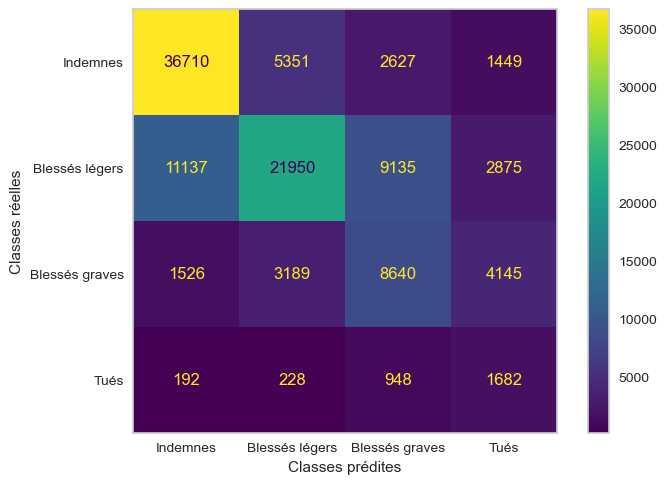

In [62]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay.from_estimator(
        model,
        data_test,
        y_test,
        display_labels=['Indemnes', 'Blessés légers', 'Blessés graves', 'Tués']
    )
disp.ax_.set(xlabel='Classes prédites', ylabel='Classes réelles')
plt.grid(False)
plt.savefig(conf['local_data_path'] + 'catboost_confusion_matrix' + '.jpg')


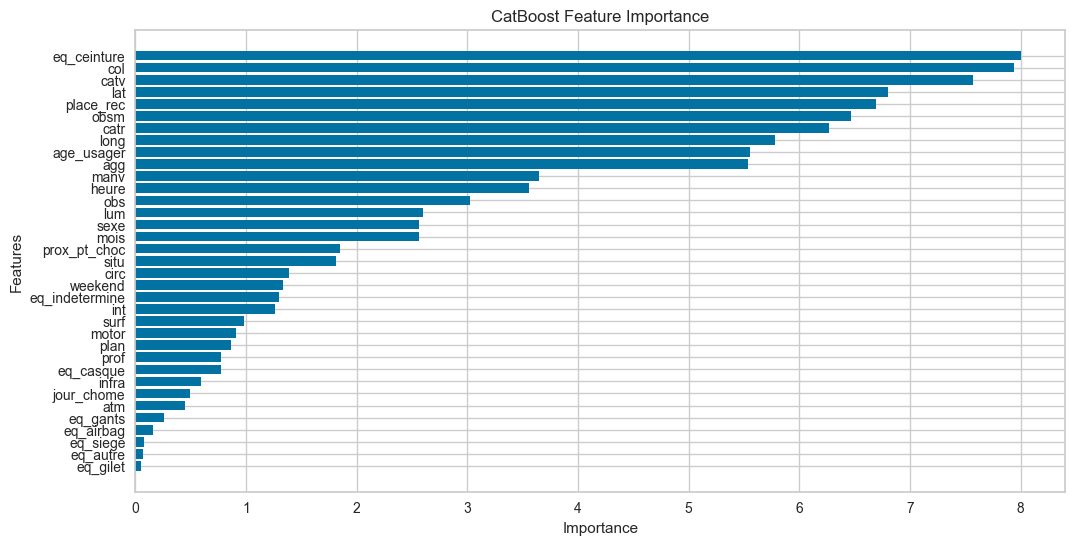

In [16]:
importances = model.get_feature_importance(type='PredictionValuesChange')
feature_importances = pd.Series(importances, index=data.columns).sort_values()
plt.figure(figsize=(12, 6))
plt.barh(feature_importances.index, feature_importances.values)
plt.title('CatBoost Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.savefig(conf['local_data_path'] + 'catboost_feature_importance' + '.jpg')